In [1]:
import os
import io
import pickle
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import wandb
from wandb.lightgbm import wandb_callback, log_summary
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Config

In [2]:
# EXP_NAME = "exp007"
EXP_NAME = "debug"

class configs:
    EXP_CATEGORY = "baseline"
    EXP_NAME = EXP_NAME
    OUTPUT_DIR = os.path.join("/workspace", "working", EXP_NAME)
    
    INPUT_DIR = os.path.join("/workspace", "input", "atmaCup15_dataset")
    ORIG_TRAIN_CSV = os.path.join(INPUT_DIR, "train.csv")
    ORIG_TEST_CSV = os.path.join(INPUT_DIR, "test.csv")
    
    TRAIN_CSV = "/workspace/working/anime_svd/train_anime2vec.csv"
    ANIME_CSV = os.path.join(INPUT_DIR, "anime.csv")
    TEST_CSV = "/workspace/working/anime_svd/test_anime2vec.csv"
    SAMPLE_SUB_CSV = os.path.join(INPUT_DIR, "sample_submission.csv")
    target_colname = "score"
    unused_cols = ["fold", "score", "oof", "seen"]
    W2V_MODEL_PATH = "/workspace/working/word2vec.gensim.model"
    
    COMPETITION = "atmaCup15"
    USER_NAME = "taro"
    wandb_available = True
    
    # train
    num_boost_round = 1000
    early_stopping_rounds = 200
    verbose_eval = 500
    FOLDS = [0, 1, 2, 3, 4]

if EXP_NAME is "debug":
    configs.wandb_available = False
    configs.num_boost_round = 10
else:
    os.makedirs(configs.OUTPUT_DIR)

In [3]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    "objective": "rmse", 
    'metric': 'rmse',
    "n_estimators": 10000, 
    "learning_rate": .01,
    "verbosity": -1, 
    "random_state": 510,
}
configs.params = params

# Utils

In [4]:
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


In [5]:
def root_mean_squared_error(y_true, y_pred):
    """mean_squared_error の root (0.5乗)"""
    return mean_squared_error(y_true, y_pred) ** .5

## utils for data

In [6]:
def merge_by_anime_id(left_df, right_df):
    return pd.merge(left_df["anime_id"], right_df, on="anime_id", how="left").drop(columns=["anime_id"])

## features func

In [7]:
def create_anime_numeric_feature(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""
    
    use_columns = [
        "members", 
    ]
    
    return merge_by_anime_id(input_df, anime_df)[use_columns]

#### label encoding

In [8]:
def create_anime_genres_label_encoding(input_df: pd.DataFrame):
    target_col = "genres"
    encoder = LabelEncoder()
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_le": encoder.fit_transform(anime_df[target_col].fillna("nan"))
    })
    return merge_by_anime_id(input_df, encoded_df)

In [9]:
def create_anime_source_label_encoding(input_df: pd.DataFrame):
    target_col = "source"
    encoder = LabelEncoder()
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_le": encoder.fit_transform(anime_df[target_col].fillna("nan"))
    })
    return merge_by_anime_id(input_df, encoded_df)

#### count encoding

In [10]:
# animeのtypeをカウントエンコーディング
def create_anime_type_count_encoding(input_df: pd.DataFrame):
    target_col = "type"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [11]:
def create_anime_studios_count_encoding(input_df: pd.DataFrame):
    target_col = "studios"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [12]:
def create_anime_producers_count_encoding(input_df: pd.DataFrame):
    target_col = "producers"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [13]:
def create_anime_animeid_count_encoding(input_df: pd.DataFrame):
    target_col = "anime_id"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

#### one-hot encoding

In [14]:
# animeのtypeをone-hotエンコーディング
def create_anime_type_one_hot_encoding(input_df: pd.DataFrame):
    # 対象の列のユニーク集合を取る
    target_colname = "type"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    # ユニークな値ごとに列を作る
    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        if value == "Unknown":
            out_df["Unknown_type"] = is_value.astype(int)
        else:
            out_df[value] = is_value.astype(int)
    
    out_df["anime_id"] = anime_df["anime_id"]
    return merge_by_anime_id(input_df, out_df)

In [15]:
# animeのtypeをone-hotエンコーディング
def create_anime_rating_one_hot_encoding(input_df: pd.DataFrame):
    # 対象の列のユニーク集合を取る
    target_colname = "rating"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    # ユニークな値ごとに列を作る
    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        if value == "Unknown":
            out_df["Unknown_rate"] = is_value.astype(int)
        else:
            out_df[value] = is_value.astype(int)
    
    out_df["anime_id"] = anime_df["anime_id"]
    return merge_by_anime_id(input_df, out_df)

### word to vec

In [16]:
def word2vec(word):
    try:
        return w2v.wv[word]
    except KeyError:
        return None


def doc2vectors(doc: str):
    words = separate_to_words(doc=doc)

    embeddings = [word2vec(w) for w in words]
    embeddings = [emb for emb in embeddings if emb is not None]
    embeddings = np.array(embeddings)

    if len(embeddings) == 0:
        print(f"- {doc}: 語彙にありませんでした.")
        return np.zeros(shape=(50,))

    # 単語ごとに要素の max を取る
    return np.max(embeddings, axis=0)

def separate_to_words(doc: str):
    """文章を単語の配列に変換する"""

    parsed_str = tagger.parse(doc).strip()
    return parsed_str.split(" ")


def create_anime_title_embedding_feature(input_df):
    # 予め作っておいた特徴量を
    embedding_df = pd.DataFrame(anime_name_vector_df.values, index=anime_df["anime_id"])

    # 入力されたデータに紐付けて
    out_df = merge_by_anime_id(input_df, embedding_df)

    # prefix を付けて返す
    return out_df.add_prefix("name_w2v_")

In [17]:
# 上で定義した関数をまとめて実行
def create_feature(input_df, config_):
    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_anime_numeric_feature,
        # label encoding
        create_anime_genres_label_encoding, 
        create_anime_source_label_encoding, 
        # count encoding
        # create_anime_type_count_encoding,
        create_anime_studios_count_encoding,
        create_anime_producers_count_encoding,
        create_anime_animeid_count_encoding, 
        # one-hot encoding
        create_anime_type_one_hot_encoding,
        create_anime_rating_one_hot_encoding,
    ]
    
    out_df = pd.DataFrame()
    func_name_list = []
    for func in functions:
        func_name = str(func.__name__)
        func_name_list.append(func_name)
        with Timer(prefix=f"create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)
    
    config_.preprocess_funcs = func_name_list
    return out_df, config_

# train func

In [18]:
def save_model(model, fold):
    save_path = os.path.join(configs.OUTPUT_DIR, f"model_fold{fold}.pkl")
    # pickle.dump(model, save_path)
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"SAVED: {save_path}")

In [19]:
def fit_lgbm(df, configs):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    models = []
    evals_results_list = [] 
    n_records = len(df)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    target = []
    for fold in configs.FOLDS: 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        train_df_ = df[df["fold"] != fold].reset_index(drop=True)
        valid_df_ = df[df["fold"] == fold].reset_index(drop=True)

        # train_df_ = df[df["fold"] != fold]
        # valid_df_ = df[df["fold"] == fold]
        idx_valid = df[df["fold"] == fold].index.values
        
        
        feat_cols = [col for col in train_df_.columns if col not in configs.unused_cols]
        print("feature nums = ", len(feat_cols))
        
        # x_train = train_df_[feat_cols]
        x_train = train_df_.drop(columns=[configs.target_colname, "fold", 'oof', 'seen', "score"])
        # print(x_train.columns)
        y_train = train_df_[configs.target_colname]
        # x_valid = valid_df_[feat_cols]
        x_valid = valid_df_.drop(columns=[configs.target_colname, "fold", 'oof', 'seen', "score"])
        y_valid = valid_df_[configs.target_colname]
        target.extend(y_valid)
        
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

        lgb_result = {}
        with Timer(prefix="fit fold={} ".format(fold)):
            if configs.wandb_available:
                clf = lgb.train(configs.params,
                                lgb_train,
                                valid_sets=[lgb_train, lgb_eval],  
                                valid_names=[f"validation_{fold}"],
                                num_boost_round=configs.num_boost_round,
                                early_stopping_rounds=configs.early_stopping_rounds,
                                evals_result=lgb_result,
                                verbose_eval=configs.verbose_eval,
                                callbacks=[wandb_callback()])
                evals_results_list.append(lgb_result)
                log_summary(clf, save_model_checkpoint=False)

            else:
                clf = lgb.train(configs.params,
                                lgb_train,
                                valid_sets=[lgb_train, lgb_eval],  
                                valid_names=[f"validation_{fold}"],
                                num_boost_round=configs.num_boost_round,
                                early_stopping_rounds=configs.early_stopping_rounds,
                                evals_result=lgb_result,
                                verbose_eval=configs.verbose_eval,
                                )
                evals_results_list.append(lgb_result)
        
        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        save_model(clf, fold)
        score = root_mean_squared_error(y_valid, pred_i)
        print(f" - fold{fold} - {score:.4f}")
        if configs.wandb_available:
            wandb.log({"fold": fold, "rmse": score})

    score = root_mean_squared_error(target, oof_pred)
    
    plt.figure(figsize=(8, 8))
    plt.hist(oof_pred, alpha=0.3, bins=50, label="oof_pred")
    plt.hist(target, alpha=0.3, bins=50, label="target")
    plt.show()
    
    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return oof_pred, target, models, evals_results_list, feat_cols

# Load data

In [20]:
anime_df = pd.read_csv(configs.ANIME_CSV)

train_df = pd.read_csv(configs.TRAIN_CSV)
test_df = pd.read_csv(configs.TEST_CSV)

original_train_df = pd.read_csv(configs.ORIG_TRAIN_CSV)
original_test_df = pd.read_csv(configs.ORIG_TEST_CSV)

In [21]:
train_df = pd.merge(train_df, original_train_df, on=["user_id", "anime_id"], how="left")
test_df = pd.merge(test_df, original_test_df, on=["user_id", "anime_id"], how="left")

## preprocess
- CountEncoding
- OneHotEncoding

In [22]:
# 実行して train / test 用の特徴量を作ります.

with Timer(prefix="train..."):
    train_feat_df, configs = create_feature(train_df, configs)

with Timer(prefix="test..."):
    test_feat_df, configs = create_feature(test_df, configs)

# X = train_feat_df.values
# print(train_feat_df.columns)
# y = train_df["score"].values


create create_anime_numeric_feature 0.048[s]
create create_anime_genres_label_encoding 0.015[s]
create create_anime_source_label_encoding 0.013[s]
create create_anime_studios_count_encoding 0.013[s]
create create_anime_producers_count_encoding 0.012[s]
create create_anime_animeid_count_encoding 0.012[s]
create create_anime_type_one_hot_encoding 0.017[s]
create create_anime_rating_one_hot_encoding 0.017[s]
train... 0.155[s]
create create_anime_numeric_feature 0.038[s]
create create_anime_genres_label_encoding 0.013[s]
create create_anime_source_label_encoding 0.010[s]
create create_anime_studios_count_encoding 0.011[s]
create create_anime_producers_count_encoding 0.010[s]
create create_anime_animeid_count_encoding 0.012[s]
create create_anime_type_one_hot_encoding 0.015[s]
create create_anime_rating_one_hot_encoding 0.016[s]
test... 0.134[s]


## utils for data

In [ ]:
def merge_by_anime_id(left_df, right_df):
    return pd.merge(left_df["anime_id"], right_df, on="anime_id", how="left").drop(columns=["anime_id"])

## features func

In [ ]:
def create_anime_numeric_feature(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""
    
    use_columns = [
        "members", 
    ]
    
    return merge_by_anime_id(input_df, anime_df)[use_columns]

#### label encoding

In [ ]:
def create_anime_genres_label_encoding(input_df: pd.DataFrame):
    target_col = "genres"
    encoder = LabelEncoder()
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_le": encoder.fit_transform(anime_df[target_col].fillna("nan"))
    })
    return merge_by_anime_id(input_df, encoded_df)

In [ ]:
def create_anime_source_label_encoding(input_df: pd.DataFrame):
    target_col = "source"
    encoder = LabelEncoder()
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_le": encoder.fit_transform(anime_df[target_col].fillna("nan"))
    })
    return merge_by_anime_id(input_df, encoded_df)

#### count encoding

In [ ]:
# animeのtypeをカウントエンコーディング
def create_anime_type_count_encoding(input_df: pd.DataFrame):
    target_col = "type"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [ ]:
def create_anime_studios_count_encoding(input_df: pd.DataFrame):
    target_col = "studios"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [ ]:
def create_anime_producers_count_encoding(input_df: pd.DataFrame):
    target_col = "producers"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

In [ ]:
def create_anime_animeid_count_encoding(input_df: pd.DataFrame):
    target_col = "anime_id"
    count = anime_df[target_col].map(anime_df["type"].value_counts())
    encoded_df = pd.DataFrame({
        "anime_id": anime_df["anime_id"],
        f"{target_col}_count": count
    })
    
    return merge_by_anime_id(input_df, encoded_df)

#### one-hot encoding

In [ ]:
# animeのtypeをone-hotエンコーディング
def create_anime_type_one_hot_encoding(input_df: pd.DataFrame):
    # 対象の列のユニーク集合を取る
    target_colname = "type"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    # ユニークな値ごとに列を作る
    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        if value == "Unknown":
            out_df["Unknown_type"] = is_value.astype(int)
        else:
            out_df[value] = is_value.astype(int)
    
    out_df["anime_id"] = anime_df["anime_id"]
    return merge_by_anime_id(input_df, out_df)

In [ ]:
# animeのtypeをone-hotエンコーディング
def create_anime_rating_one_hot_encoding(input_df: pd.DataFrame):
    # 対象の列のユニーク集合を取る
    target_colname = "rating"
    target_series = anime_df[target_colname]
    unique_values = target_series.unique()

    # ユニークな値ごとに列を作る
    out_df = pd.DataFrame()
    for value in unique_values:
        is_value = target_series == value
        if value == "Unknown":
            out_df["Unknown_rate"] = is_value.astype(int)
        else:
            out_df[value] = is_value.astype(int)
    
    out_df["anime_id"] = anime_df["anime_id"]
    return merge_by_anime_id(input_df, out_df)

### word to vec

In [ ]:
def word2vec(word):
    try:
        return w2v.wv[word]
    except KeyError:
        return None


def doc2vectors(doc: str):
    words = separate_to_words(doc=doc)

    embeddings = [word2vec(w) for w in words]
    embeddings = [emb for emb in embeddings if emb is not None]
    embeddings = np.array(embeddings)

    if len(embeddings) == 0:
        print(f"- {doc}: 語彙にありませんでした.")
        return np.zeros(shape=(50,))

    # 単語ごとに要素の max を取る
    return np.max(embeddings, axis=0)

def separate_to_words(doc: str):
    """文章を単語の配列に変換する"""

    parsed_str = tagger.parse(doc).strip()
    return parsed_str.split(" ")


def create_anime_title_embedding_feature(input_df):
    # 予め作っておいた特徴量を
    embedding_df = pd.DataFrame(anime_name_vector_df.values, index=anime_df["anime_id"])

    # 入力されたデータに紐付けて
    out_df = merge_by_anime_id(input_df, embedding_df)

    # prefix を付けて返す
    return out_df.add_prefix("name_w2v_")

In [ ]:
# 上で定義した関数をまとめて実行
def create_feature(input_df, config_):
    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_anime_numeric_feature,
        # label encoding
        create_anime_genres_label_encoding, 
        create_anime_source_label_encoding, 
        # count encoding
        # create_anime_type_count_encoding,
        create_anime_studios_count_encoding,
        create_anime_producers_count_encoding,
        create_anime_animeid_count_encoding, 
        # one-hot encoding
        create_anime_type_one_hot_encoding,
        create_anime_rating_one_hot_encoding,
    ]
    
    out_df = pd.DataFrame()
    func_name_list = []
    for func in functions:
        func_name = str(func.__name__)
        func_name_list.append(func_name)
        with Timer(prefix=f"create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)
    
    config_.preprocess_funcs = func_name_list
    return out_df, config_

In [23]:
input_df = pd.concat([train_df, train_feat_df], axis=1)
input_df = input_df.drop(["user_id", "anime_id"], axis=1)

In [24]:
input_df.columns

Index(['wo_score_user_factor_0', 'wo_score_user_factor_1',
       'wo_score_user_factor_2', 'wo_score_user_factor_3',
       'wo_score_user_factor_4', 'wo_score_user_factor_5',
       'wo_score_user_factor_6', 'wo_score_user_factor_7',
       'wo_score_user_factor_8', 'wo_score_user_factor_9',
       'wo_score_user_factor_10', 'wo_score_user_factor_11',
       'wo_score_user_factor_12', 'wo_score_user_factor_13',
       'wo_score_user_factor_14', 'wo_score_user_factor_15',
       'wo_score_user_factor_16', 'wo_score_user_factor_17',
       'wo_score_user_factor_18', 'wo_score_user_factor_19',
       'wo_score_user_factor_20', 'wo_score_user_factor_21',
       'wo_score_user_factor_22', 'wo_score_user_factor_23',
       'wo_score_user_factor_24', 'wo_score_user_factor_25',
       'wo_score_user_factor_26', 'wo_score_user_factor_27',
       'wo_score_user_factor_28', 'wo_score_user_factor_29',
       'wo_score_user_factor_30', 'wo_score_user_factor_31',
       'wo_score_user_factor_32', 

# Train

In [25]:
if configs.wandb_available:
   WANDB_CONFIG = {'competition': "atma15", '_wandb_kernel': "taro"}
   os.environ["WANDB_SILENT"] = "true"
   # config_dict = dict(vars(configs))
   wandb.init(project=WANDB_CONFIG["competition"],
               # config=config_dict,
               group=configs.EXP_CATEGORY, 
               name=configs.EXP_NAME,
               reinit=True,
               save_code=True)
   print("wandb initialized")
else:
   print("wandb logging is not available")

wandb logging is not available


feature nums =  85
Training until validation scores don't improve for 200 rounds
[500]	validation_0's rmse: 1.1631	valid_1's rmse: 1.18687
[1000]	validation_0's rmse: 1.14574	valid_1's rmse: 1.18504
[1500]	validation_0's rmse: 1.13176	valid_1's rmse: 1.18453
[2000]	validation_0's rmse: 1.11824	valid_1's rmse: 1.18383
[2500]	validation_0's rmse: 1.10556	valid_1's rmse: 1.18371
Early stopping, best iteration is:
[2468]	validation_0's rmse: 1.10632	valid_1's rmse: 1.18368
fit fold=0  15.883[s]
SAVED: /workspace/working/debug/model_fold0.pkl
 - fold0 - 1.1837
feature nums =  85
Training until validation scores don't improve for 200 rounds
[500]	validation_1's rmse: 1.16369	valid_1's rmse: 1.18364
[1000]	validation_1's rmse: 1.14627	valid_1's rmse: 1.18214
[1500]	validation_1's rmse: 1.13136	valid_1's rmse: 1.18101
[2000]	validation_1's rmse: 1.11722	valid_1's rmse: 1.18004
[2500]	validation_1's rmse: 1.10475	valid_1's rmse: 1.17954
[3000]	validation_1's rmse: 1.09313	valid_1's rmse: 1.1794

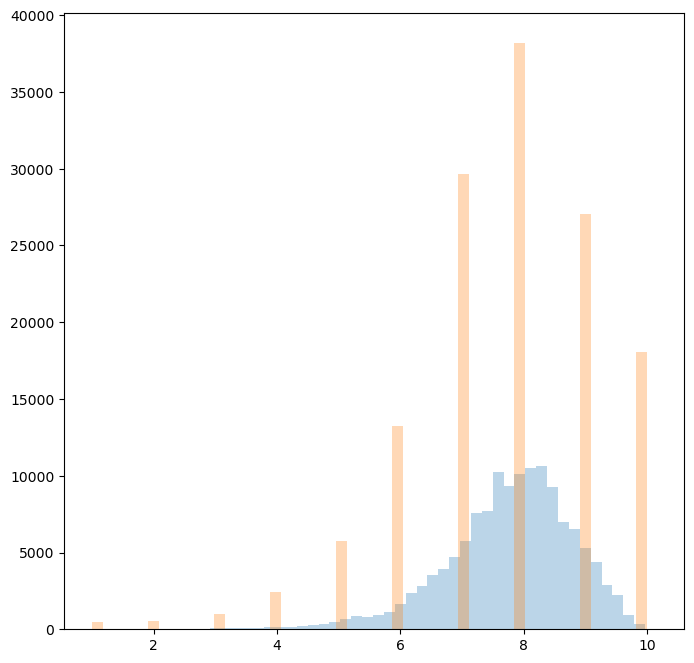

FINISHI: Whole Score: 1.8808


In [26]:
oof, target, models, evals_results, feat_cols = fit_lgbm(input_df, configs)

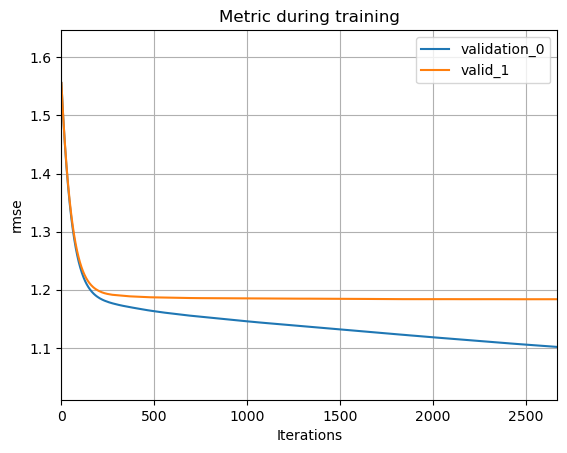

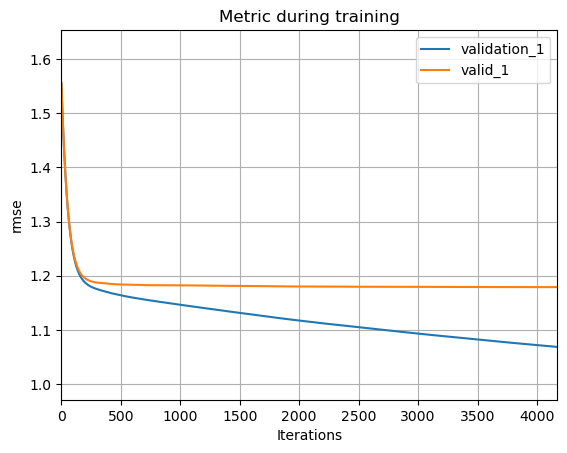

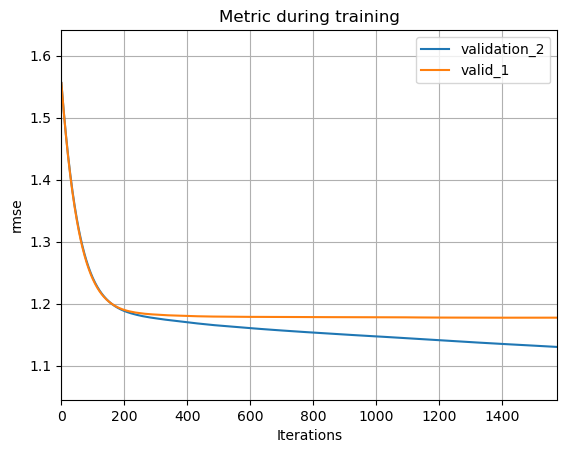

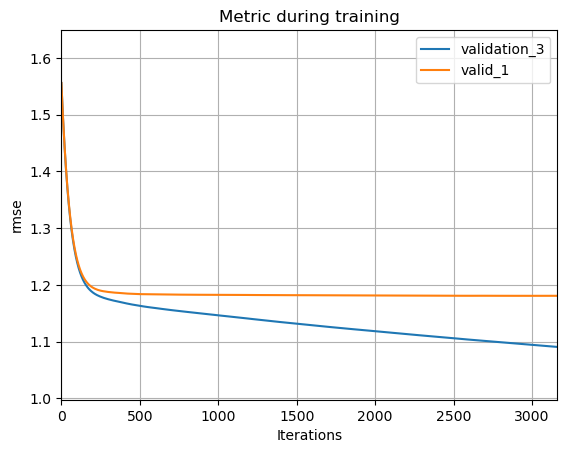

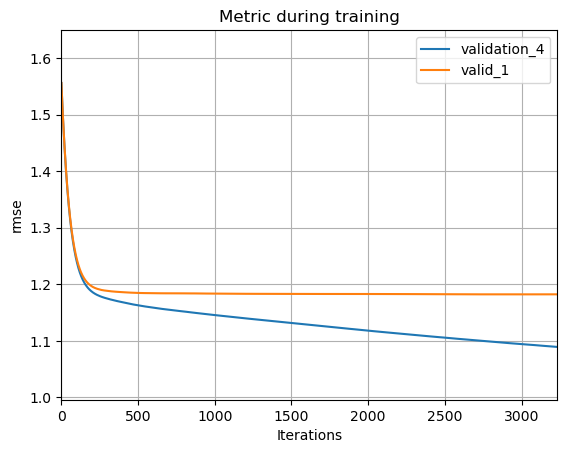

In [27]:
for evals in evals_results:
    lgb.plot_metric(evals, metric="rmse")

# Result

In [28]:
oof_score = root_mean_squared_error(y_true=target, y_pred=oof)
print(oof_score)

1.880752453275606


### result distribution

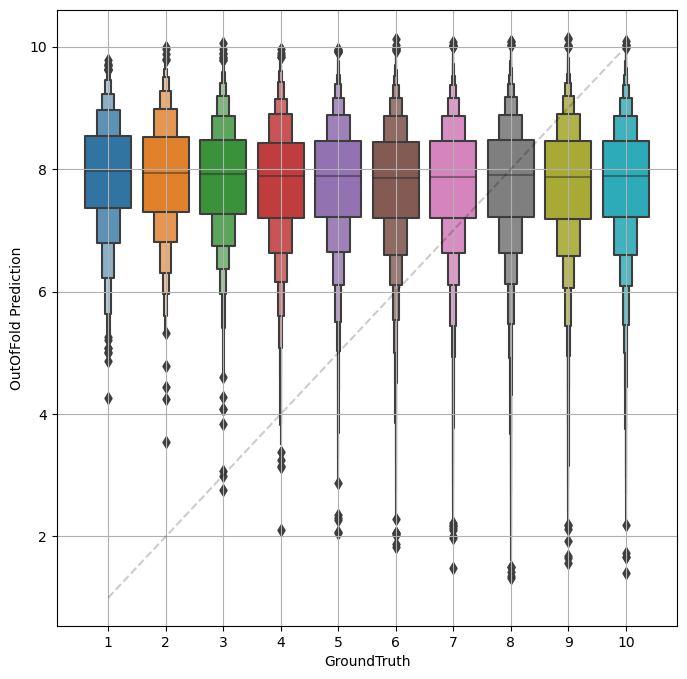

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxenplot(data=pd.DataFrame({ "GroundTruth": target, "OutOfFold Prediction": oof }), 
              x="GroundTruth", y="OutOfFold Prediction", ax=ax)

ax.grid()
ax.plot([0, 9], [1, 10], "--", c="black", alpha=.2)

### result importance

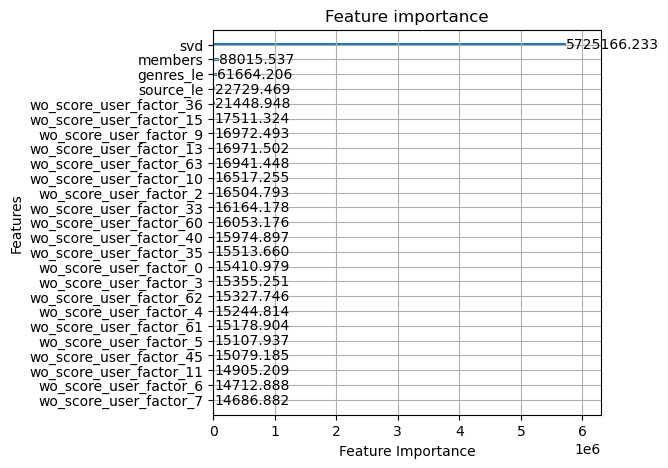

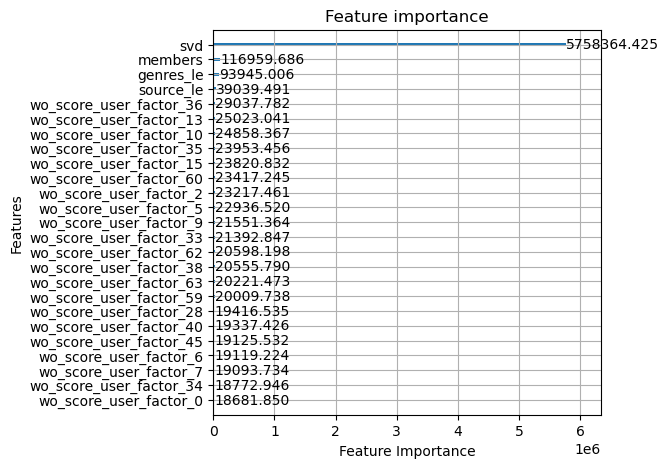

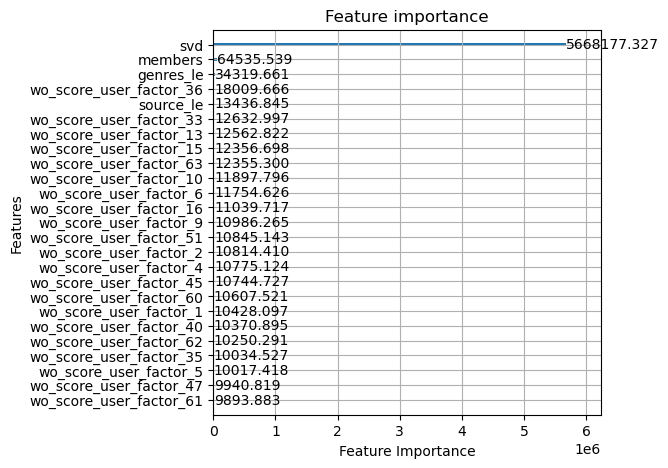

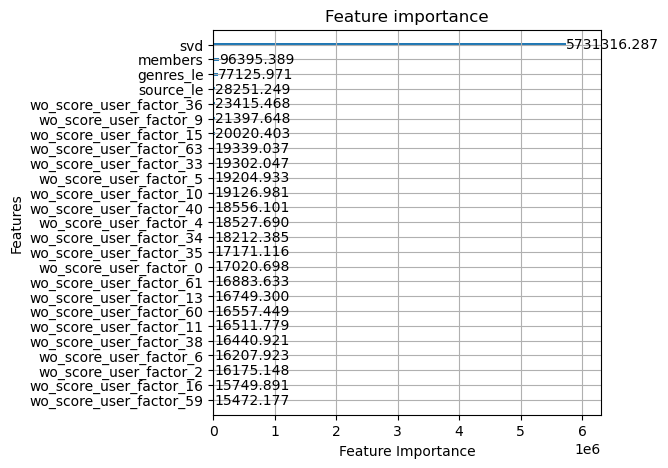

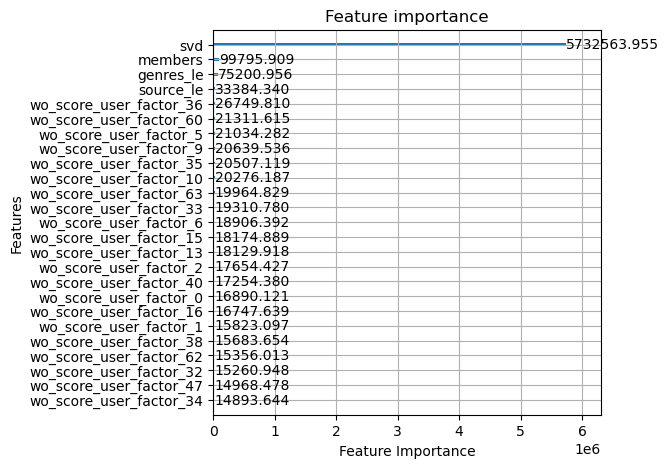

In [30]:
for idx, model in enumerate(models):
    lgb.plot_importance(model, figsize=(5,5),
                        importance_type="gain", max_num_features=25, 
                        xlabel="Feature Importance", ylabel="Features")

# Inference

['svd', 'members', 'tyoe_count', 'TV', 'Special', 'Movie', 'Unknown','ONA', 'OVA', 'Music']

In [31]:
# input_columns = [col for col in input_df.columns if col not in ["fold", "score", "oof", "seen", "score"]]
# print(input_columns)
print(feat_cols)
print(len(feat_cols))

['wo_score_user_factor_0', 'wo_score_user_factor_1', 'wo_score_user_factor_2', 'wo_score_user_factor_3', 'wo_score_user_factor_4', 'wo_score_user_factor_5', 'wo_score_user_factor_6', 'wo_score_user_factor_7', 'wo_score_user_factor_8', 'wo_score_user_factor_9', 'wo_score_user_factor_10', 'wo_score_user_factor_11', 'wo_score_user_factor_12', 'wo_score_user_factor_13', 'wo_score_user_factor_14', 'wo_score_user_factor_15', 'wo_score_user_factor_16', 'wo_score_user_factor_17', 'wo_score_user_factor_18', 'wo_score_user_factor_19', 'wo_score_user_factor_20', 'wo_score_user_factor_21', 'wo_score_user_factor_22', 'wo_score_user_factor_23', 'wo_score_user_factor_24', 'wo_score_user_factor_25', 'wo_score_user_factor_26', 'wo_score_user_factor_27', 'wo_score_user_factor_28', 'wo_score_user_factor_29', 'wo_score_user_factor_30', 'wo_score_user_factor_31', 'wo_score_user_factor_32', 'wo_score_user_factor_33', 'wo_score_user_factor_34', 'wo_score_user_factor_35', 'wo_score_user_factor_36', 'wo_score_

In [32]:
test_df = pd.concat([test_df, test_feat_df], axis=1)
test_df = test_df[feat_cols]
print(test_df.columns)
print(len(test_df.columns))

Index(['wo_score_user_factor_0', 'wo_score_user_factor_1',
       'wo_score_user_factor_2', 'wo_score_user_factor_3',
       'wo_score_user_factor_4', 'wo_score_user_factor_5',
       'wo_score_user_factor_6', 'wo_score_user_factor_7',
       'wo_score_user_factor_8', 'wo_score_user_factor_9',
       'wo_score_user_factor_10', 'wo_score_user_factor_11',
       'wo_score_user_factor_12', 'wo_score_user_factor_13',
       'wo_score_user_factor_14', 'wo_score_user_factor_15',
       'wo_score_user_factor_16', 'wo_score_user_factor_17',
       'wo_score_user_factor_18', 'wo_score_user_factor_19',
       'wo_score_user_factor_20', 'wo_score_user_factor_21',
       'wo_score_user_factor_22', 'wo_score_user_factor_23',
       'wo_score_user_factor_24', 'wo_score_user_factor_25',
       'wo_score_user_factor_26', 'wo_score_user_factor_27',
       'wo_score_user_factor_28', 'wo_score_user_factor_29',
       'wo_score_user_factor_30', 'wo_score_user_factor_31',
       'wo_score_user_factor_32', 

In [33]:
print(test_df.columns[:30])
print(test_df.columns[30:60])
print(test_df.columns[60:90])
print(test_df.columns[90:])

Index(['wo_score_user_factor_0', 'wo_score_user_factor_1',
       'wo_score_user_factor_2', 'wo_score_user_factor_3',
       'wo_score_user_factor_4', 'wo_score_user_factor_5',
       'wo_score_user_factor_6', 'wo_score_user_factor_7',
       'wo_score_user_factor_8', 'wo_score_user_factor_9',
       'wo_score_user_factor_10', 'wo_score_user_factor_11',
       'wo_score_user_factor_12', 'wo_score_user_factor_13',
       'wo_score_user_factor_14', 'wo_score_user_factor_15',
       'wo_score_user_factor_16', 'wo_score_user_factor_17',
       'wo_score_user_factor_18', 'wo_score_user_factor_19',
       'wo_score_user_factor_20', 'wo_score_user_factor_21',
       'wo_score_user_factor_22', 'wo_score_user_factor_23',
       'wo_score_user_factor_24', 'wo_score_user_factor_25',
       'wo_score_user_factor_26', 'wo_score_user_factor_27',
       'wo_score_user_factor_28', 'wo_score_user_factor_29'],
      dtype='object')
Index(['wo_score_user_factor_30', 'wo_score_user_factor_31',
       'wo_

In [34]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test_df.values) for model in models])


# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0) # axis=0 なので shape の `k` が潰れる 

## Inference predictions

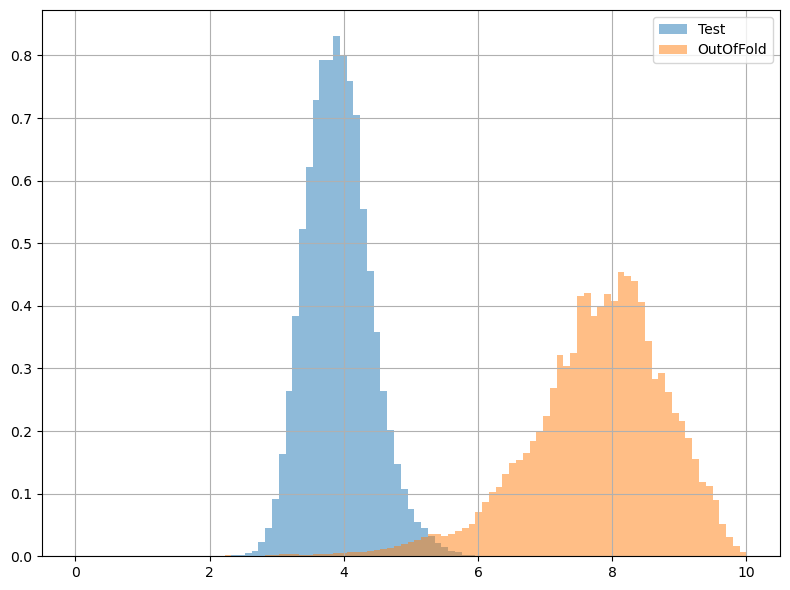

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(pred, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(oof, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

# save infer csv

In [36]:
pd.DataFrame({
    "score": pred
}).to_csv(os.path.join(configs.OUTPUT_DIR, "submission.csv"), index=False)


In [37]:
oof_score

1.880752453275606

In [38]:
if configs.wandb_available:
    wandb.log({"oof_score": oof_score})
    wandb.finish()